In [9]:
from PIL import Image
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from IPython.display import display

In [10]:
device = "cuda"if torch.cuda.is_available() else "cpu"
print("Device using:", device)

Device using: cuda


In [11]:
class ImageDataset(Dataset):
    def __init__(self,data_dir,transform=None,maxdata=100):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.max_image = maxdata
        label_list = []
        image_list = []
        once = True
        for phase in os.listdir(data_dir):
            phase_path = os.path.join(data_dir,phase)
            for label in os.listdir(phase_path):
                label_path = os.path.join(phase_path,label)
                num=0
                for file in os.listdir(label_path):
                    if num>maxdata:
                        break
                    file_path = os.path.join(label_path,file)
                    image = Image.open(file_path)
                    patch_div = 4
                    patch_len = image.size[1]//patch_div
                    # print(patch_len)
                    if once: 
                        display(image)
                        once = False
                    patches = []
                    for i in range(patch_div):
                        for j in range(patch_div):
                            patch = image.crop((j*patch_len,i*patch_len,(j+1)*patch_len,(i+1)*patch_len))
                            if self.transform:
                                patch = self.transform(patch)
                            patch_tensor = torch.tensor(np.array(patch),dtype = torch.float32, device=device)
                            # print(patch_tensor.shape)
                            patches.append(patch_tensor)
                    # all_patches_tensor = torch.stack(patches)
                    image_list.append(torch.stack(patches))
                    label_list.append(label)
                    # print(all_patches_tensor.shape)
                    # patch_len = image.size[1]//8
                    # print(patch_len)
                    # for i in range(8):
                    #     for j in range(8):
                    #         patch = image.crop((j*patch_len,i*patch_len,(j+1)*patch_len,(i+1)*patch_len))
                    # if self.transform:
                    #     patch = self.transform(image)
                    # patch_tensor = torch.tensor(np.array(patch),dtype = torch.float32, device=device)
                    # # patch_tensor=patch_tensor.squeeze(0)
                    # image_list.append(patch_tensor)
                    # label_list.append(label)
                    # num +=1
            if phase == 'train': self.data = pd.DataFrame(zip(image_list,label_list))
            elif phase == 'val': self.valdata = pd.DataFrame(zip(image_list,label_list))
            print(len(image_list),len(label_list))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        # image = Image.open(self.data.iloc[index,0]).convert('L')
        # if self.transform:
        #     image = self.transform(image)
        return self.data[0][index],self.data.iloc[index,1]
    def save_data(self,save_dir):
        if not os.path.exists(save_dir):
            print("directory not exist")
            return
        Dataset_dic = {
            "data":self.data[0],
            "label":self.data[1],
            "valdata":self.valdata[0],
            "vallabel":self.valdata[1]
        }
        torch.save(Dataset_dic,save_dir)
        print("dataset saved in ",save_dir)

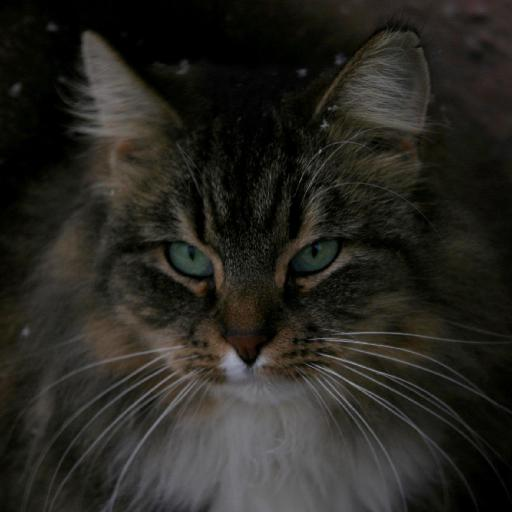

In [ ]:
transform = transforms.Compose([
    # transforms.Resize((112, 112), interpolation=transforms.InterpolationMode.BICUBIC),
    # transforms.CenterCrop(299),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
BASE_DIR = os.path.abspath(os.getcwd())
data = ImageDataset(os.path.join(BASE_DIR,"afhq"),transform=transform,maxdata=10)
# print(data.data[0].shape)
# data.save_data(os.path.join(BASE_DIR,"Cleaned_data.pt"))